# Imports

In [1]:
import LightPipes as lp
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

# Functions

In [2]:
def plot_Field(Field: lp.field.Field, cmap="jet", title="Field") -> None:
    """
        Given an intensity array I and the extent (in mm) of the image, plot it and its intensity through the middle.
    """
    # Get the intensity
    I = lp.Intensity(Field, flag=0)

    # Get the size
    size = Field.siz

    # Array size
    N = Field.N

    # Setup subplots
    cols = 2
    rows = 1
    plt.figure(figsize=(6 * cols, 5 * rows))

    # Plot the field image
    plt.subplot(rows, cols, 1)
    plt.imshow(I, extent=(0, size / lp.mm, 0, size / lp.mm), cmap=cmap)
    plt.colorbar()
    plt.title(title + f" N={N}")
    plt.xlabel('Position (mm)')
    plt.ylabel('Position (mm)')

    # Plot the field Intensity
    plt.subplot(rows, cols, 2)
    xx = (np.arange(N)/N * size - (size / 2))

    plt.plot(xx * (1/lp.mm), I[N//2], label="Simulation")
    plt.title("Intensity profile through the center")
    plt.xlabel("x position (mm)")
    plt.ylabel("Intensity (a.u.)")
    plt.grid("on")

# Gaussian Beam and Second Pass Through a Lens

zR = 124114.7540135032mm
5.016202800239086
[[ -1.  -19.8]
 [  0.   -1. ]]


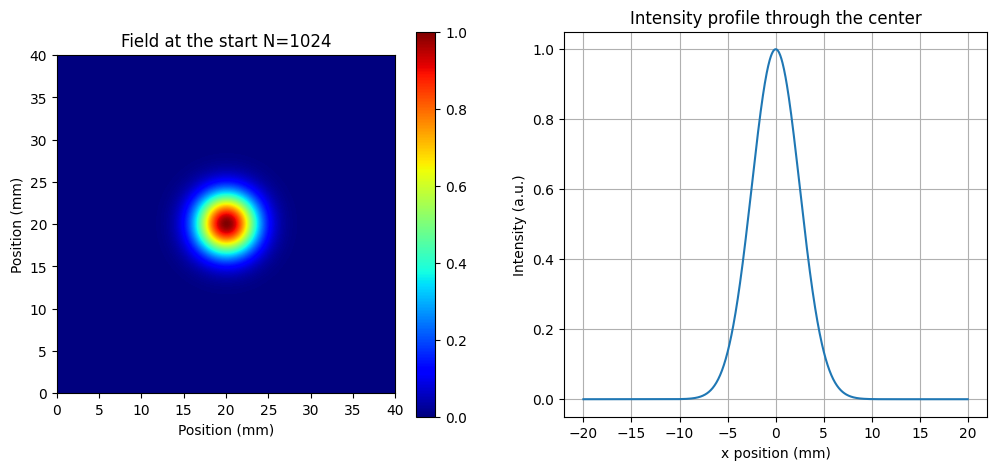

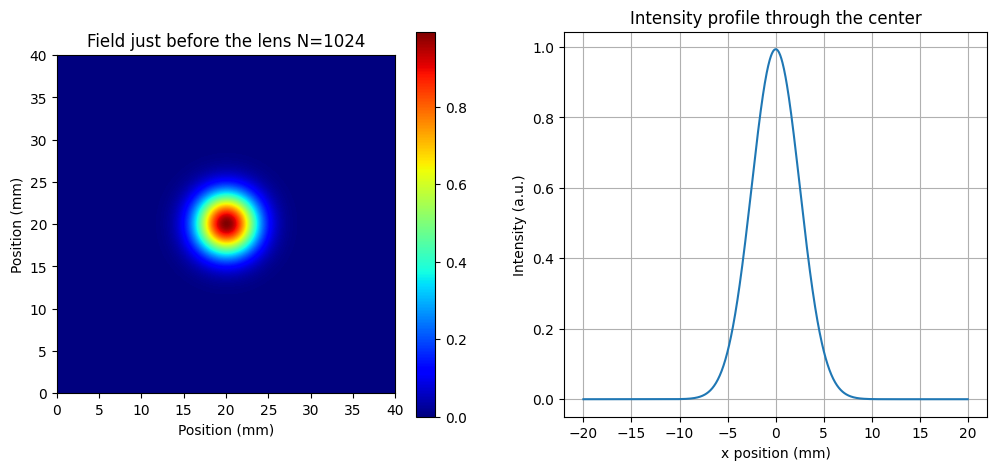

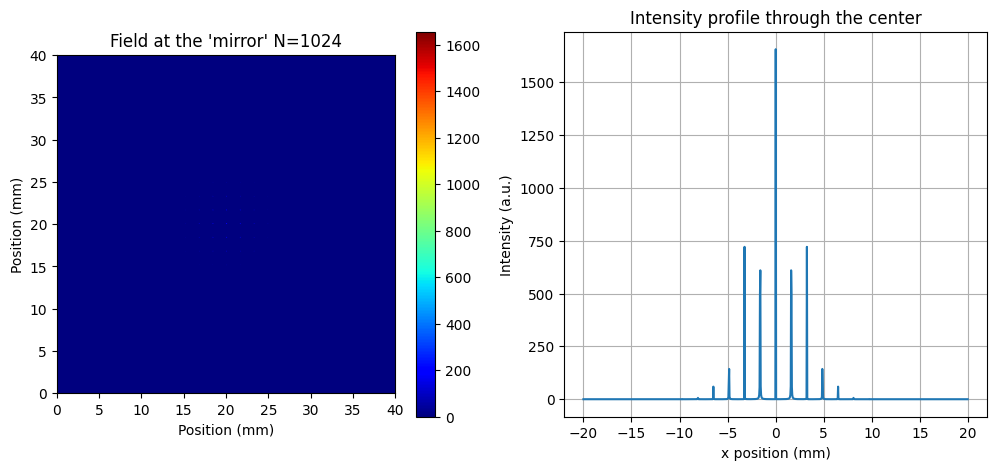

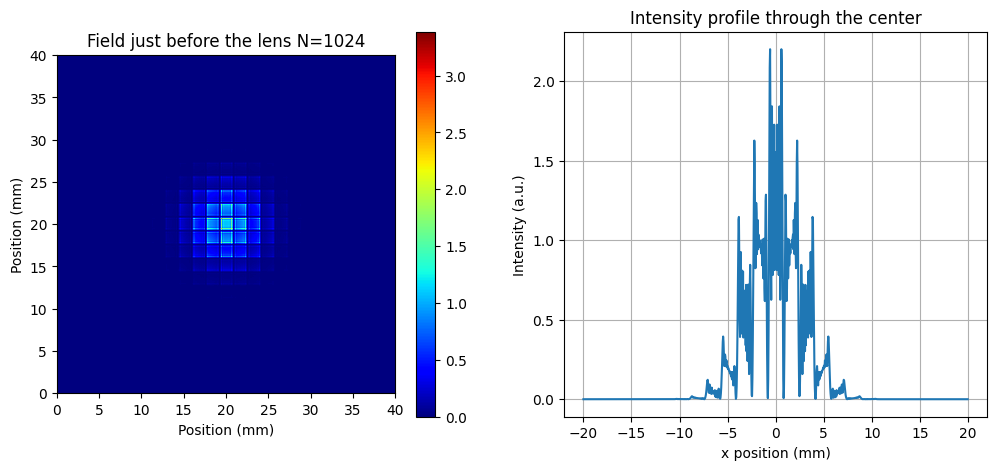

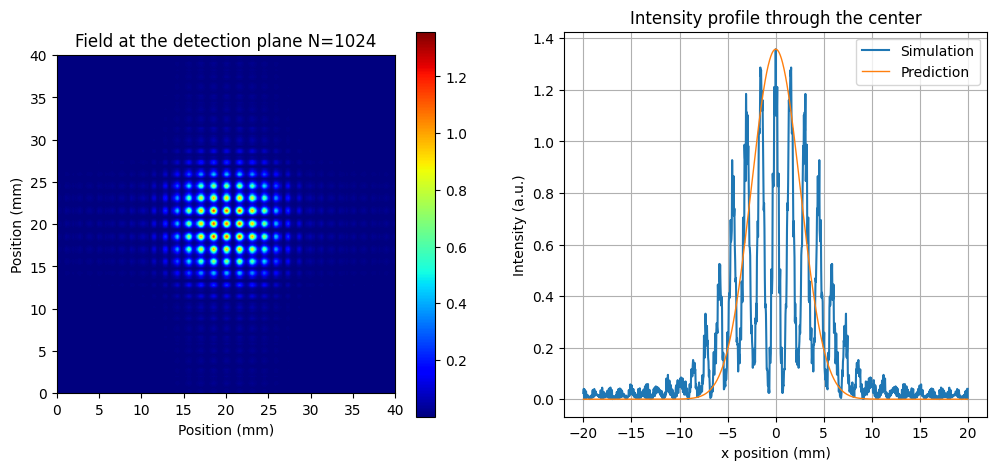

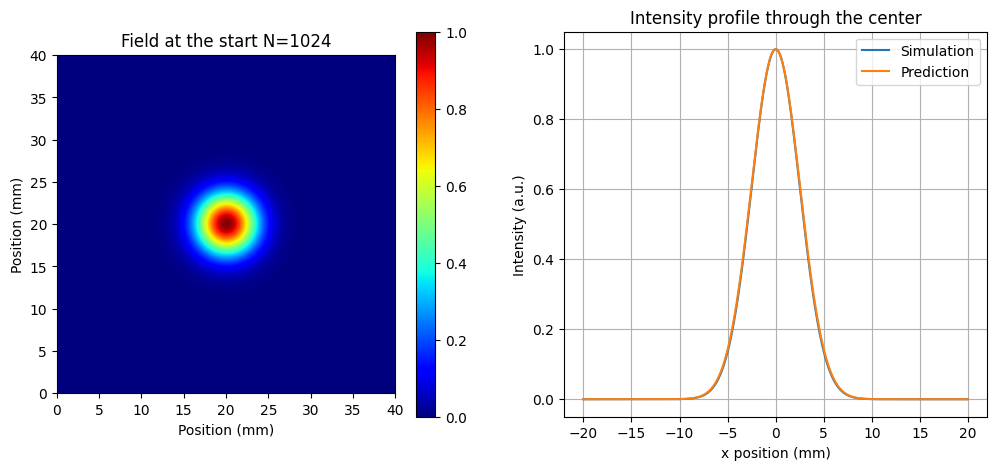

In [10]:
# Parameters
size = 40 * lp.mm # size of the grid
wave = 632.8 * lp.nm # wavelength of HeNe laser
N = 2**10 # number (NxN) of grid pixels
h = size / N

wave = 632.8 * lp.nm # wavelength of HeNe laser

# Laser Beam Settings
k = 2 * np.pi / wave
w0 = 5 * lp.mm # laser beam waist
zr = np.pi * w0**2 / wave

print(f"zR = {zr / lp.mm}mm")

# Parameters
dl = 10 * lp.m # distance from the lens to 0
f = 10 * lp.m # focal length of the lens


# Create the beam
Field = lp.Begin(size, wave, N)
Field = lp.GaussBeam(Field, w0)
plot_Field(Field, title="Field at the start")

# Propagate the laser some distance
Field = lp.Forvard(Field, dl)
plot_Field(Field, title="Field just before the lens")


# Pass the beam through the lens and propagate up to the focus
Field = lp.Lens(Field, f)
Field = lp.Forvard(Field, f)
plot_Field(Field, title="Field at the 'mirror'")

I = lp.Intensity(Field, flag=0)
# print(I[N//2, N//2 - 10: N//2 + 10])


# Beam waist after lens
wlens = (wave * (dl**2 + zr**2) / (np.pi * zr))**(0.5)
print(wlens / lp.mm)


# "Reflect" the beam and propagate back to the lens
Field = lp.Forvard(Field, f)
plot_Field(Field, title="Field just before the lens")


# Propagate to the detection plane
Field = lp.Lens(Field, f)
Field = lp.Forvard(Field, dl)
plot_Field(Field, title="Field at the detection plane")


# Predict the beam using the beam parameter
I = lp.Intensity(Field, flag=0)
Imax = np.max(I[N//2])


# ABCD matriz for: propagtion -> lens -> propagation -> lens -> propagation
prop1 = np.array([[1, dl], [0, 1]])
prop2 = np.array([[1, f], [0, 1]])
lens = np.array([[1, 0], [-1/f, 1]])
ABCD = prop1 @ lens @ prop2 @ prop2 @ lens @ prop1
print(ABCD)


# Beam parameter calculated using ABCD matrices
q0 = 1j * np.pi * w0**2 / wave
qz = (ABCD[0, 0] * q0 + ABCD[0, 1]) / (ABCD[1, 0] * q0 + ABCD[1, 1])

# Beam parameter through the lens
xx = np.arange(N)/N * size - (size / 2)
yy = np.abs(np.exp((-1j * k * xx**2) / (2 * qz)))**2

plt.plot(xx / lp.mm, Imax * yy, label="Prediction", lw=1)
plt.legend()
plt.show()


# Compare with starting field
Field = lp.Begin(size, wave, N)
Field = lp.GaussBeam(Field, w0)

I = lp.Intensity(Field, flag=0)
Imax = np.max(I[N//2])

plot_Field(Field, title="Field at the start")
plt.plot(xx / lp.mm, Imax * yy, label="Prediction")
plt.legend()
plt.show()

## Exact Integration

[[-1.  0.]
 [ 0. -1.]]


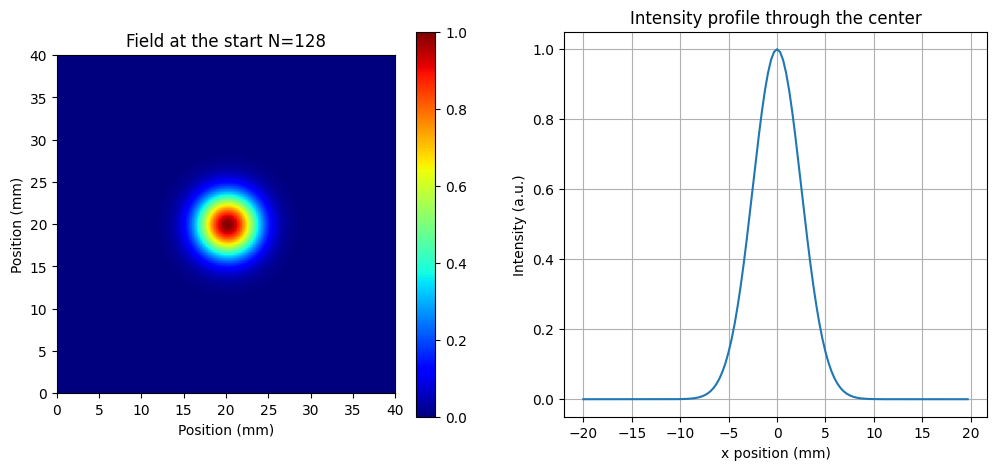

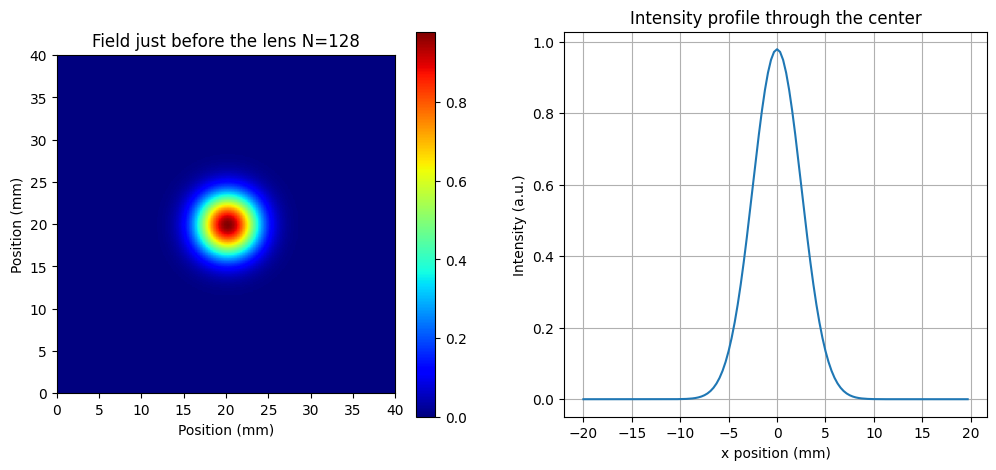

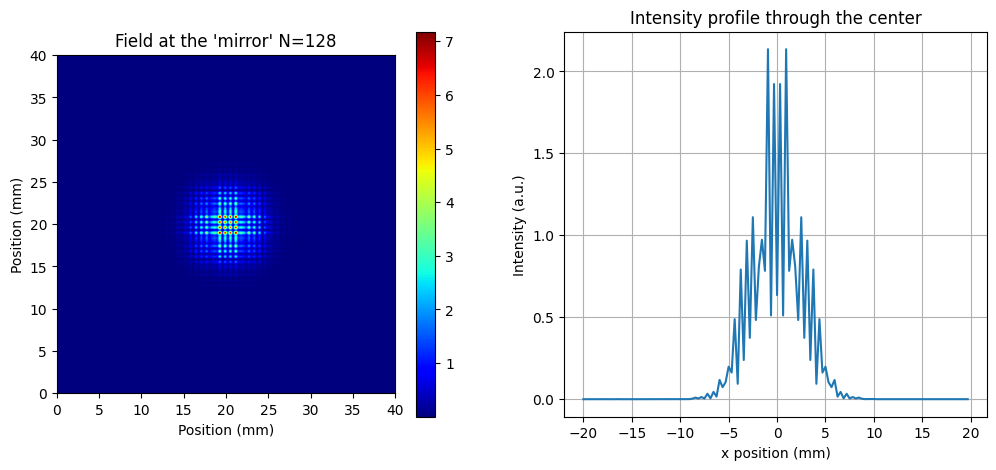

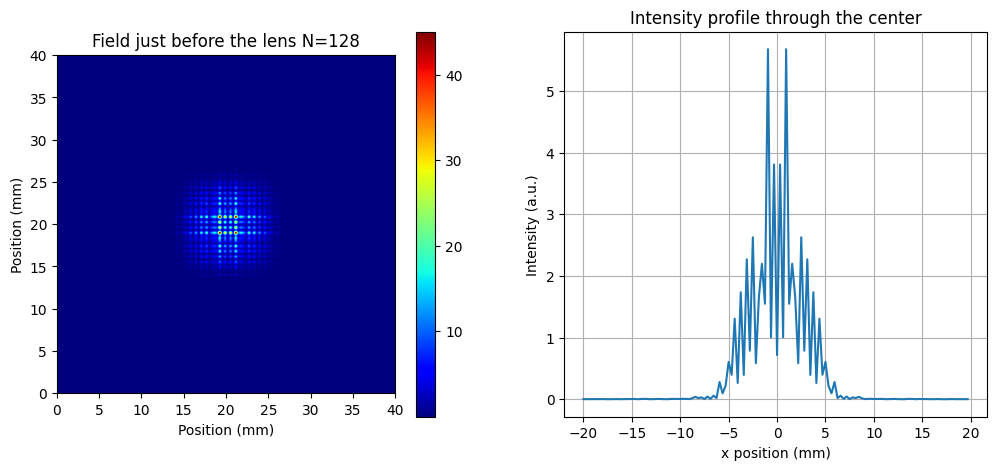

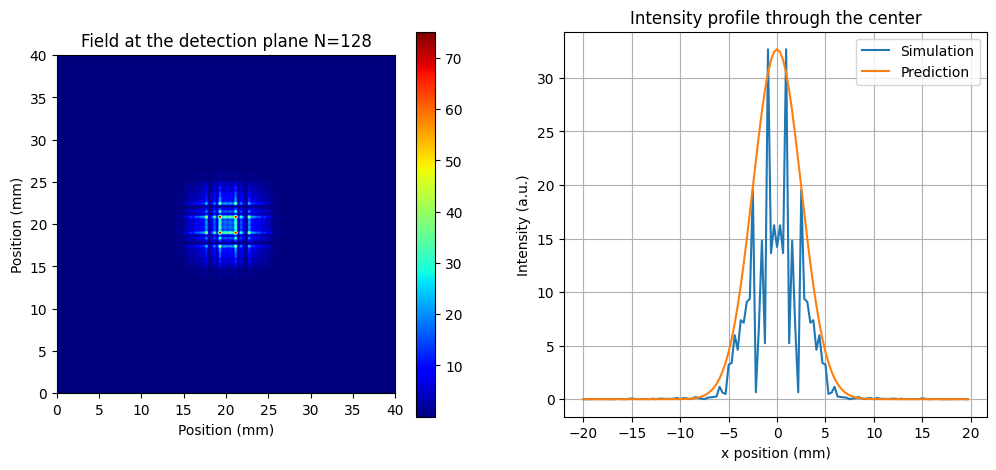

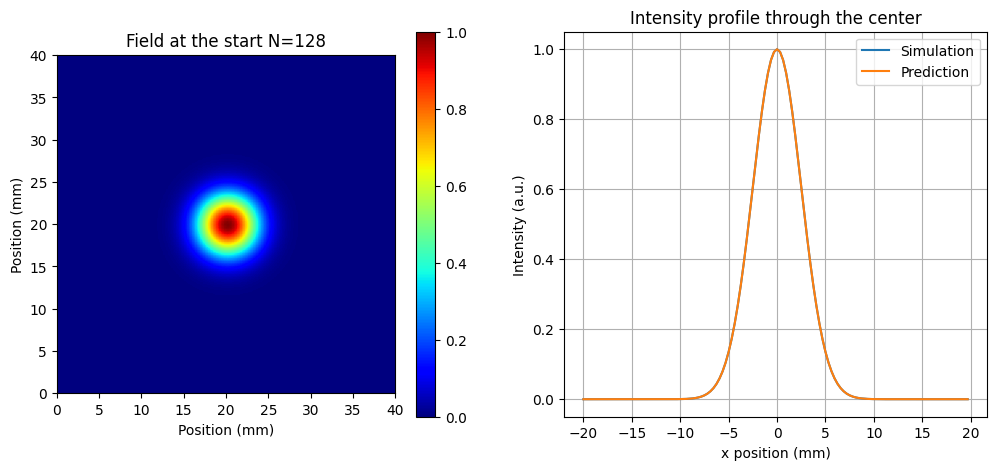

In [4]:
# Parameters
size = 40 * lp.mm # size of the grid
wave = 632.8 * lp.nm # wavelength of HeNe laser
N = 128 # number (NxN) of grid pixels
h = size / N

k = 2 * np.pi / wave

# Laser Beam
w0 = 5 * lp.mm # laser beam waist

# Parameters
dl = 10 * lp.cm # distance from the lens to 0
f = 10 * lp.cm # focal length of the lens


# Create the beam
Field = lp.Begin(size, wave, N)
Field = lp.GaussBeam(Field, w0)
plot_Field(Field, title="Field at the start")

# Propagate the laser some distance
Field = lp.Forward(Field, dl, size, N)
plot_Field(Field, title="Field just before the lens")


# Pass the beam through the lens and propagate up to the focus
Field = lp.Lens(Field, f)
Field = lp.Forward(Field, f, size, N)
plot_Field(Field, title="Field at the 'mirror'")


# "Reflect" the beam and propagate back to the lens
Field = lp.Forward(Field, f, size, N)
plot_Field(Field, title="Field just before the lens")


# Propagate to the detection plane
Field = lp.Lens(Field, f)
Field = lp.Forward(Field, dl, size, N)
plot_Field(Field, title="Field at the detection plane")


# Predict the beam using the beam parameter
I = lp.Intensity(Field, flag=0)
Imax = np.max(I[N//2])

# ABCD matriz of the propagtion -> lens -> propagation -> lens -> propagation
prop1 = np.array([[1, dl], [0, 1]])
prop2 = np.array([[1, f], [0, 1]])
lens = np.array([[1, 0], [-1/f, 1]])
ABCD = prop1 @ (lens @ (prop2 @ (prop2 @ (lens @ prop1))))
print(ABCD)


# Beam parameter calculated using ABCD matrices
q0 = 1j * np.pi * w0**2 / wave
qz = (ABCD[0, 0] * q0 + ABCD[0, 1]) / (ABCD[1, 0] * q0 + ABCD[1, 1])

# Beam parameter through the lens
xx = np.arange(N)/N * size - (size / 2)
yy = np.abs(np.exp((-1j * k * xx**2) / (2 * qz)))**2

plt.plot(xx / lp.mm, Imax * yy, label="Prediction")
plt.legend()
plt.show()


# Compare with starting field
Field = lp.Begin(size, wave, N)
Field = lp.GaussBeam(Field, w0)

I = lp.Intensity(Field, flag=0)
Imax = np.max(I[N//2])

plot_Field(Field, title="Field at the start")
plt.plot(xx / lp.mm, Imax * yy, label="Prediction")
plt.legend()
plt.show()